In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error

In [6]:


df = pd.read_csv(r"C:\Users\Thanush\OneDrive\Documents\Data set\profit_analysis.csv")
print(df.head())
print(df.tail())

    RD_Spend  Administration  Marketing_Spend       State     Profit
0  165349.20       136897.80        471784.10    New York  192261.83
1  162597.70       151377.59        443898.53  California  191792.06
2  153441.51       101145.55        407934.54     Florida  191050.39
3  144372.41       118671.85        383199.62    New York  182901.99
4  142107.34        91391.77        366168.42     Florida  166187.94
    RD_Spend  Administration  Marketing_Spend       State    Profit
45   1000.23       124153.04          1903.93    New York  64926.08
46   1315.46       115816.21        297114.46     Florida  49490.75
47      0.00       135426.92             0.00  California  42559.73
48    542.05        51743.15             0.00    New York  35673.41
49      0.00       116983.80         45173.06  California  14681.40


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RD_Spend         50 non-null     float64
 1   Administration   50 non-null     float64
 2   Marketing_Spend  50 non-null     float64
 3   State            50 non-null     object 
 4   Profit           50 non-null     float64
dtypes: float64(4), object(1)
memory usage: 2.1+ KB


In [5]:
df.describe()

,RD_Spend,Administration,Marketing_Spend,Profit
count,50.000000,50.000000,50.000000,50.000000
mean,73721.615600,121344.639600,211025.097800,112012.639200
std,45902.256482,28017.802755,122290.310726,40306.180338
min,0.000000,51283.140000,0.000000,14681.400000
25%,39936.370000,103730.875000,129300.132500,90138.902500
50%,73051.080000,122699.795000,212716.240000,107978.190000
75%,101602.800000,144842.180000,299469.085000,139765.977500
max,165349.200000,182645.560000,471784.100000,192261.830000


In [7]:
df.isnull().sum()

RD_Spend           0
Administration     0
Marketing_Spend    0
State              0
Profit             0
dtype: int64

In [8]:
df = df.drop_duplicates()

In [10]:
# fill numeric nulls with median, categorical nulls with mode

for c in df.select_dtypes(include = [np.number]).columns:
    df[c] = df[c].fillna(df[c].median())
for c in df.select_dtypes(include =['object','category']).columns:
    df[c] = df[c].fillna(df[c].mode()[0])


In [13]:
(df == 0).sum()

RD_Spend           2
Administration     0
Marketing_Spend    3
State              0
Profit             0
dtype: int64

In [25]:
df["RD_Spend"] = df["RD_Spend"].replace(0, df["RD_Spend"].median())

# Add interaction column
df["RDxMarketing"] = df["RD_Spend"] * df["Marketing_Spend"]

# One-hot encode State
df = pd.get_dummies(df, columns=["State"], drop_first=True)

In [30]:
# features and Target values
X = df[["RD_Spend","Administration","Marketing_Spend"]] # Features
y = df["Profit"]  # Target

# Train and test
X_train,X_test,y_train,y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

# model
model = LinearRegression()
model.fit(X_train, y_train)

# --- evaluate ---
pred_test = model.predict(X_test)
print("Test R2:", round(r2_score(y_test, pred_test),4))
print("Test RMSE:",np.sqrt(round(mean_squared_error(y_test, pred_test),4)))

# --- predict given inputs ---
new_rows = pd.DataFrame({
    "RD_Spend":[21892.92,23940.93],
    "Administration":[81910.77,96489.63],
    "Marketing_Spend":[164270.7,137001.1]
})

preds = model.predict(new_rows)
print("\nPredictions for provided rows:")
for i,p in enumerate(preds,1):
    print(f" Row {i}: {p:.2f}")


Test R2: 0.6383
Test RMSE: 17114.91881622872

Predictions for provided rows:
 Row 1: 69722.52
 Row 2: 67571.63


In [31]:
coef_df = pd.DataFrame({
    "Feature": X.columns,
    "Coefficient": model.coef_
}).sort_values(by="Coefficient", key=lambda x: abs(x), ascending=False)

print(coef_df)

           Feature  Coefficient
0         RD_Spend     0.605433
2  Marketing_Spend     0.131593
1   Administration     0.013559


In [32]:
# ---- PREDICT ALL ROWS FOR POWER BI ----
df["Predicted_Profit"] = model.predict(X)
df["Residual"] = df["Profit"] - df["Predicted_Profit"]
df["Abs_Error"] = df["Residual"].abs()
df["Pct_Error"] = df["Abs_Error"] / df["Profit"].replace(0, np.nan) * 100

# Save to CSV
df.to_csv("profit_with_predictions.csv", index=False)
print("Saved: profit_with_predictions.csv")

Saved: profit_with_predictions.csv


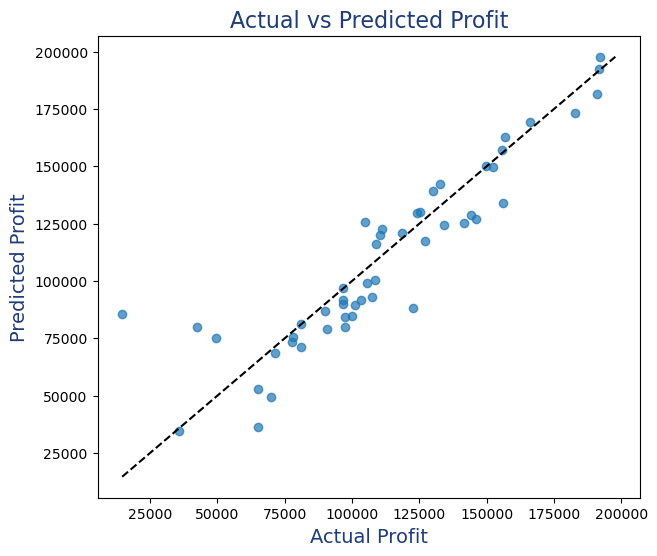

In [52]:


plt.figure(figsize=(7,6))
plt.scatter(df["Profit"], df["Predicted_Profit"], color="#1f77b4", alpha=0.7)

# Perfect prediction line
min_val = min(df["Profit"].min(), df["Predicted_Profit"].min())
max_val = max(df["Profit"].max(), df["Predicted_Profit"].max())
plt.plot([min_val, max_val], [min_val, max_val], '--', color="black")

plt.title("Actual vs Predicted Profit", fontsize=16, color="#1f3d7a")
plt.xlabel("Actual Profit", fontsize=14, color="#1f3d7a")
plt.ylabel("Predicted Profit", fontsize=14, color="#1f3d7a")

plt.show()


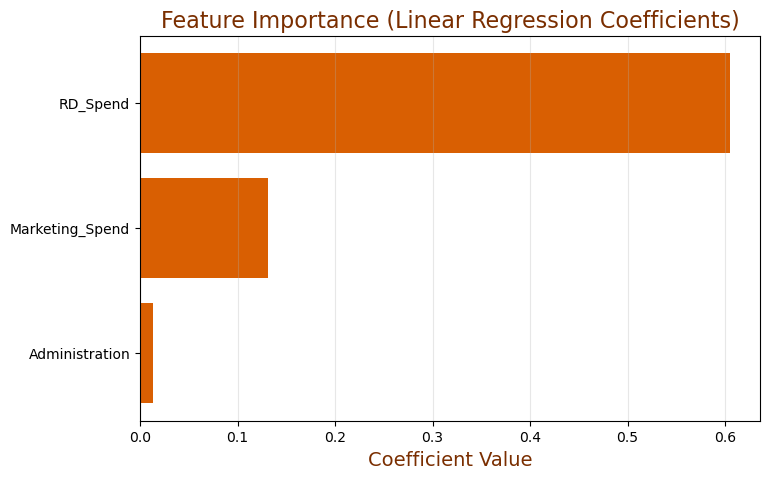

In [53]:
feature_names = X.columns
coefs = model.coef_

coef_df = pd.DataFrame({"Feature": feature_names, "Coefficient": coefs})
coef_df = coef_df.sort_values(by="Coefficient", key=lambda x: abs(x), ascending=False)

plt.figure(figsize=(8,5))
plt.barh(coef_df["Feature"], coef_df["Coefficient"], color="#d95f02")
plt.title("Feature Importance (Linear Regression Coefficients)", fontsize=16, color="#7a2e00")
plt.xlabel("Coefficient Value", fontsize=14, color="#7a2e00")

plt.grid(alpha=0.3, axis="x")
plt.gca().invert_yaxis()  # show biggest on top
plt.show()


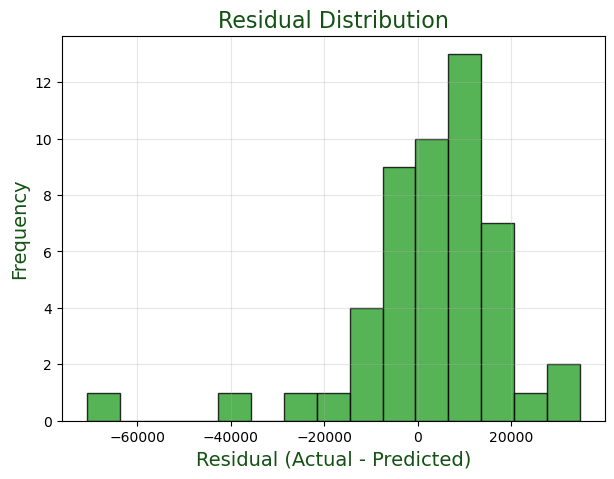

In [43]:
plt.figure(figsize=(7,5))
plt.hist(df["Residual"], bins=15, color="#2ca02c", alpha=0.8, edgecolor="black")

plt.title("Residual Distribution", fontsize=16, color="#145214")
plt.xlabel("Residual (Actual - Predicted)", fontsize=14, color="#145214")
plt.ylabel("Frequency", fontsize=14, color="#145214")

plt.grid(alpha=0.3)
plt.show()


In [54]:
print(df.columns)

Index(['RD_Spend', 'Administration', 'Marketing_Spend', 'Profit',
       'RDxMarketing', 'State_Florida', 'State_New York', 'Predicted_Profit',
       'Residual', 'Abs_Error', 'Pct_Error'],
      dtype='object')


In [56]:
df_original = pd.read_csv(r"C:\Users\Thanush\OneDrive\Documents\Data set\profit_analysis.csv")
df_original["Predicted_Profit"] = df["Predicted_Profit"]
df_original["Residual"] = df["Residual"]
df_original["Pct_Error"] = df["Pct_Error"]

df_original.to_csv("profit_with_predictions1.csv", index=False)